In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
FILE_PATH = 'banknote_net.feather'
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 1e-5
SCHEDULER_FACTOR = 0.5
SCHEDULER_PATIENCE = 10

In [4]:
df = pd.read_feather(FILE_PATH)
df = df.drop(columns=['Denomination'])
df.head()

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_247,v_248,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency
0,0.423395,0.327657,2.568988,3.166228,4.801421,5.531792,2.458083,1.218453,0.000000,1.116785,...,3.429449,0.000000,2.273451,5.790633,0.000000,0.000000,0.0,5.635400,0.000000,AUD
1,1.158823,1.669602,3.638447,2.823524,4.839890,2.777757,0.753350,0.764005,0.347871,1.928572,...,3.991283,0.000000,2.329623,3.516146,0.000000,0.000000,0.0,2.548191,1.053410,AUD
2,0.000000,0.958235,4.706119,1.688242,3.312702,4.516483,0.000000,1.876461,2.250795,1.883192,...,0.000000,0.811282,5.591417,1.879267,0.641139,0.571079,0.0,1.861483,2.172145,AUD
3,0.920511,1.820294,3.939334,3.206829,6.253655,0.942557,2.952453,0.000000,2.064298,1.367196,...,1.807719,1.764936,3.415151,2.518404,0.582229,1.105192,0.0,1.566918,0.533945,AUD
4,0.331918,0.000000,3.330771,3.023437,4.369099,5.177336,1.499362,0.590646,0.553625,1.405708,...,2.418198,0.000000,4.615945,4.825463,0.302261,0.378229,0.0,2.710654,0.325945,AUD


In [5]:
LABEL_MAP = {currency: index for index, currency in enumerate(df['Currency'].unique())}
LABEL_MAP

{'AUD': 0,
 'BRL': 1,
 'CAD': 2,
 'EUR': 3,
 'GBP': 4,
 'IDR': 5,
 'INR': 6,
 'JPY': 7,
 'MXN': 8,
 'MYR': 9,
 'NNR': 10,
 'NZD': 11,
 'PHP': 12,
 'PKR': 13,
 'SGD': 14,
 'TRY': 15,
 'USD': 16}

In [6]:
df['Currency'] = df['Currency'].map(LABEL_MAP)
df

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_247,v_248,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency
0,0.423395,0.327657,2.568988,3.166228,4.801421,5.531792,2.458083,1.218453,0.000000,1.116785,...,3.429449,0.000000,2.273451,5.790633,0.000000,0.000000,0.000000,5.635400,0.000000,0
1,1.158823,1.669602,3.638447,2.823524,4.839890,2.777757,0.753350,0.764005,0.347871,1.928572,...,3.991283,0.000000,2.329623,3.516146,0.000000,0.000000,0.000000,2.548191,1.053410,0
2,0.000000,0.958235,4.706119,1.688242,3.312702,4.516483,0.000000,1.876461,2.250795,1.883192,...,0.000000,0.811282,5.591417,1.879267,0.641139,0.571079,0.000000,1.861483,2.172145,0
3,0.920511,1.820294,3.939334,3.206829,6.253655,0.942557,2.952453,0.000000,2.064298,1.367196,...,1.807719,1.764936,3.415151,2.518404,0.582229,1.105192,0.000000,1.566918,0.533945,0
4,0.331918,0.000000,3.330771,3.023437,4.369099,5.177336,1.499362,0.590646,0.553625,1.405708,...,2.418198,0.000000,4.615945,4.825463,0.302261,0.378229,0.000000,2.710654,0.325945,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24821,0.000000,3.076672,1.849998,0.635259,6.472688,0.000000,2.214436,0.000000,2.988177,3.404484,...,0.000000,4.631783,2.729344,0.000000,1.506066,0.000000,1.067279,3.900349,0.004177,16
24822,0.000000,4.471694,2.024621,0.194067,6.469818,0.000000,1.756854,0.000000,3.129118,4.005479,...,0.000000,4.721860,2.495226,0.000000,2.055333,0.000000,1.332700,4.545783,0.030185,16
24823,0.000000,3.726544,1.780134,1.752426,3.299378,0.422422,0.527200,0.504323,2.486856,0.927679,...,0.000000,3.888309,1.271812,0.000000,0.000000,0.676830,0.510450,2.906571,0.363790,16
24824,0.250622,2.615436,1.329533,0.741571,5.485542,0.000000,2.267793,0.000000,2.881907,2.511872,...,0.000000,4.994749,0.000000,0.000000,2.440658,0.000000,0.737470,4.139810,0.314729,16


In [7]:
X, y = df.drop(columns=['Currency']), df['Currency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=420)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
X_test_tensor = torch.FloatTensor(X_test.values).to(device)

y_train_tensor = torch.LongTensor(y_train.values).to(device)
y_val_tensor = torch.LongTensor(y_val.values).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_dim = X_train.shape[1]
output_dim = len(y_train.unique())
print(f"Input = {input_dim}, Output = {output_dim}")

Input = 256, Output = 17


In [13]:
class CurrencyDetector(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(CurrencyDetector, self).__init__()

        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)

        self.fc6 = nn.Linear(32, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.dropout(self.relu(self.bn5(self.fc5(x))))
        x = self.fc6(x)

        return x

In [14]:
model = CurrencyDetector(input_dim, output_dim, DROPOUT_RATE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)

# Early stopping variables
best_test_acc = 0.0
patience = SCHEDULER_PATIENCE
patience_counter = 0

Trainable parameters: 308,689
Epoch 01: Train Loss 1.0596 | Val Loss 0.3207 | Train Acc 0.6983 | Val Acc 0.9043 | LR 0.01
Epoch 02: Train Loss 0.4848 | Val Loss 0.2353 | Train Acc 0.8734 | Val Acc 0.9366 | LR 0.01
Epoch 03: Train Loss 0.3667 | Val Loss 0.2363 | Train Acc 0.9079 | Val Acc 0.9426 | LR 0.01
Epoch 04: Train Loss 0.3366 | Val Loss 0.1694 | Train Acc 0.9166 | Val Acc 0.9542 | LR 0.01
Epoch 05: Train Loss 0.2777 | Val Loss 0.1511 | Train Acc 0.9298 | Val Acc 0.9607 | LR 0.01
Epoch 06: Train Loss 0.2569 | Val Loss 0.1674 | Train Acc 0.9359 | Val Acc 0.9557 | LR 0.01
Epoch 07: Train Loss 0.2434 | Val Loss 0.1538 | Train Acc 0.9397 | Val Acc 0.9612 | LR 0.01
Epoch 08: Train Loss 0.2264 | Val Loss 0.1713 | Train Acc 0.9449 | Val Acc 0.9562 | LR 0.01
Epoch 09: Train Loss 0.2188 | Val Loss 0.1431 | Train Acc 0.9482 | Val Acc 0.9637 | LR 0.01
Epoch 10: Train Loss 0.2032 | Val Loss 0.1519 | Train Acc 0.9524 | Val Acc 0.9612 | LR 0.01
Epoch 11: Train Loss 0.1914 | Val Loss 0.1513 | Tr

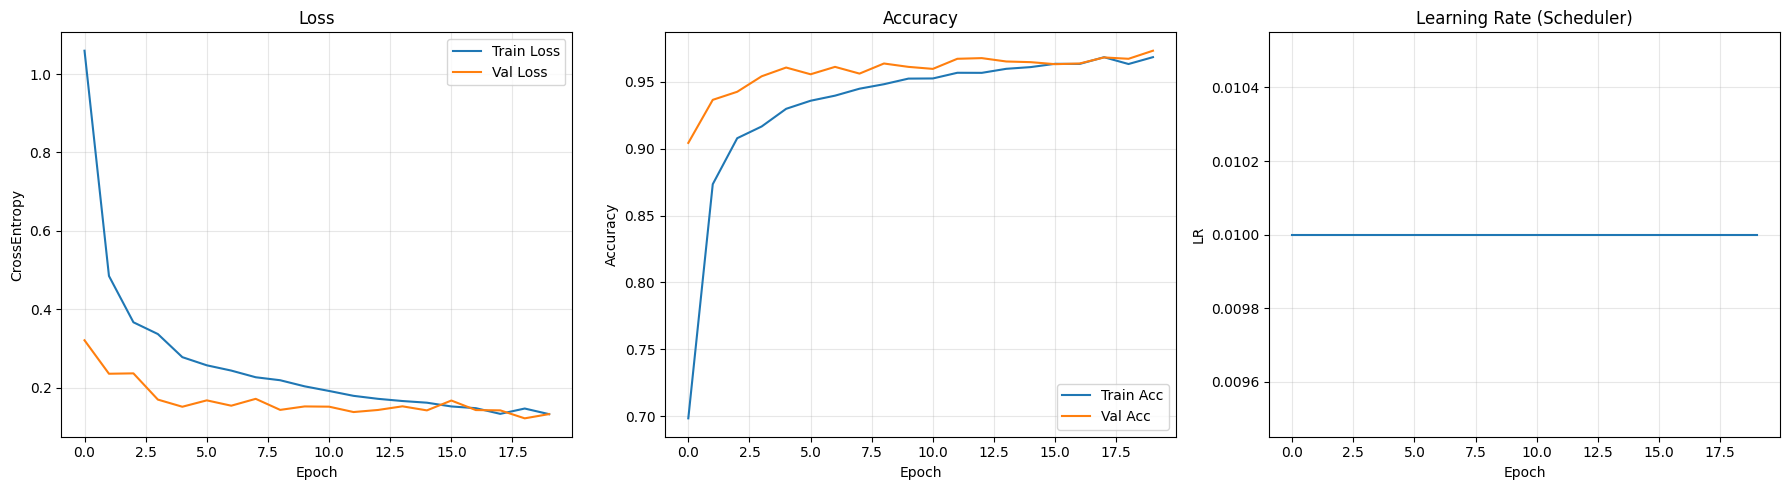

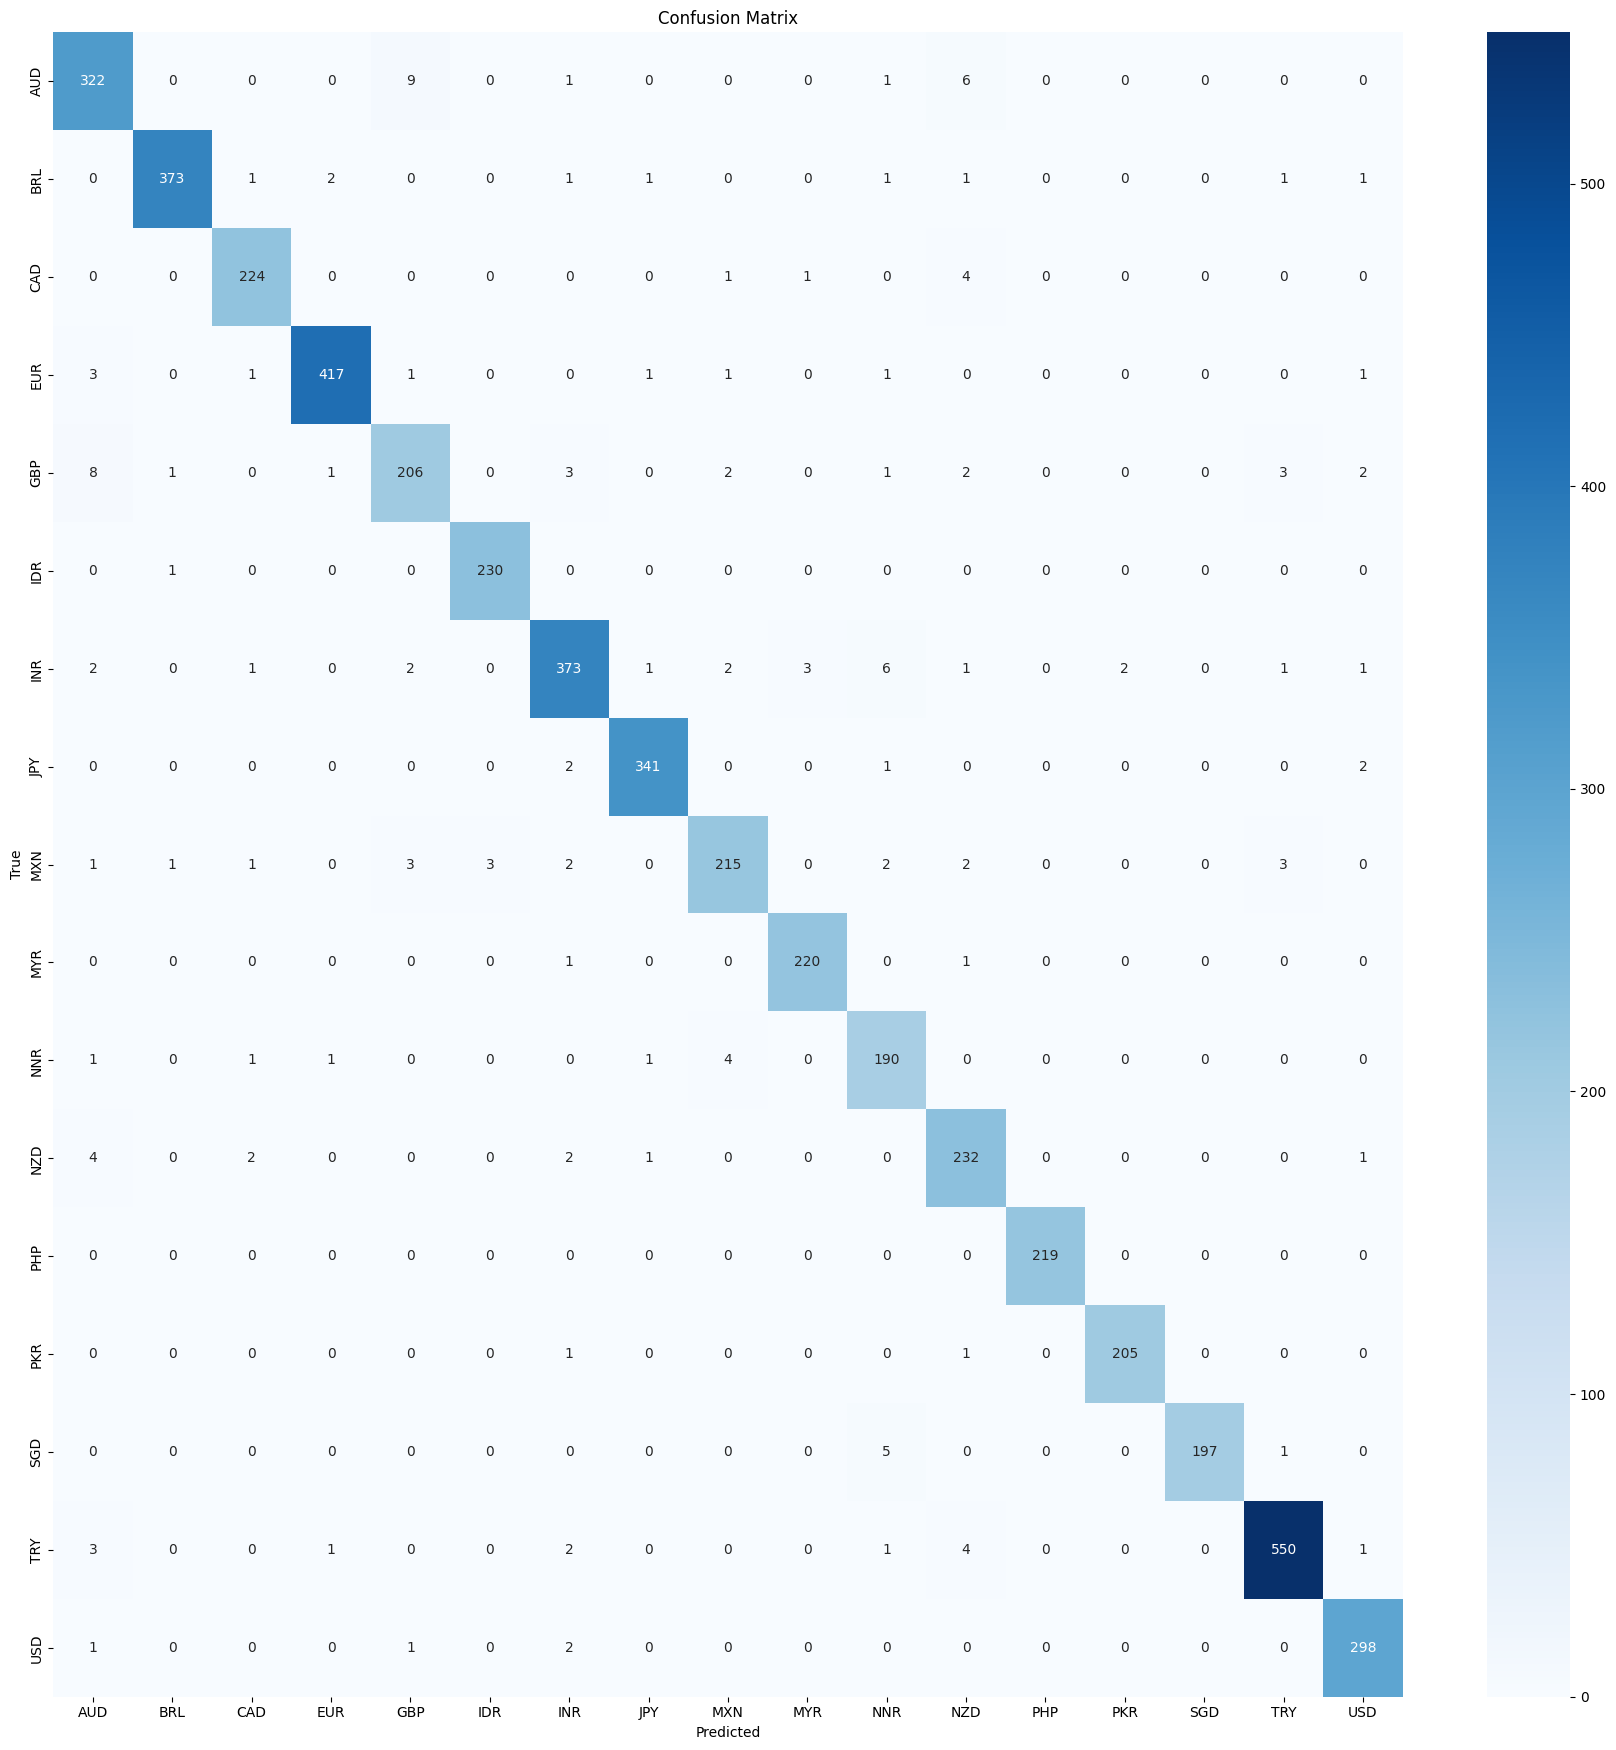

Macro F1: 0.9677 | Weighted F1: 0.9690
Objective Metric (Macro F1): 0.9677


In [15]:
# ================== Training / Evaluation Utilities ==================
import time, copy, seaborn as sns
from pathlib import Path

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")

# Optional: set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "lr": []
}

early_patience = 10
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

max_grad_norm = 5.0  # gradient clipping

start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        running_acc += (out.argmax(1) == yb).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_acc / len(train_loader.dataset)

    # ---- Validate ----
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            vloss = criterion(out, yb)
            val_running_loss += vloss.item() * xb.size(0)
            val_running_acc += (out.argmax(1) == yb).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_running_acc / len(val_loader.dataset)

    # Scheduler on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | "
          f"Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f} | LR {current_lr:g}")

    # ---- Early Stopping ----
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_patience:
            print(f"Early stopping at epoch {epoch}")
            break

total_time = time.time() - start_time
print(f"Training time: {total_time:.1f}s")

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

# ================== Test Evaluation ==================
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

test_acc = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Reverse label map for readability
inv_label_map = {v: k for k, v in LABEL_MAP.items()}

print("\nClassification Report:")
print(classification_report(
    all_targets,
    all_preds,
    target_names=[inv_label_map[i] for i in range(len(inv_label_map))],
    digits=4
))

cm = confusion_matrix(all_targets, all_preds)

# ================== Visualizations ==================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("CrossEntropy")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history["train_acc"], label="Train Acc")
axes[1].plot(history["val_acc"], label="Val Acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Learning rate
axes[2].plot(history["lr"])
axes[2].set_title("Learning Rate (Scheduler)")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("LR")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(0.8*len(inv_label_map)+4, 0.8*len(inv_label_map)+4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[inv_label_map[i] for i in range(len(inv_label_map))],
    yticklabels=[inv_label_map[i] for i in range(len(inv_label_map))]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Macro / weighted F1 (for quick hyperparam objective)
from sklearn.metrics import f1_score
macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")
print(f"Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f}")

# Suggest objective metric for tuning
objective_metric = macro_f1
print(f"Objective Metric (Macro F1): {objective_metric:.4f}")